Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Loading the packages

In [ ]:
!pip install pycm livelossplot
!pip install torchsummary
%pylab inline

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
import random
import pandas as pd
from PIL import Image as pil_image
import csv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from torchvision import models
from itertools import chain

In [ ]:
import os 
import sys
sys.path.append("/content/gdrive/MyDrive/edsmlproj2")

from Tools_Speed.modelSpeed import RMSELoss, PretrainedWindModel
from Tools_Speed.WindSpeedDataset import DatasetWIND
from Tools_Speed.UtilsSpeed import set_seed, create_df, to_csv, create_test_df

Check for GPU

In [ ]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


Creation of Dataframe

In [ ]:
csv_file_name = '/content/gdrive/MyDrive/edsmlproj2/combined_storm.csv'
df = create_df(csv_file_name)
df

,storm_id,relative_time,ocean,wind_speed,image_file_name,images_per_storm,image_path,pct_of_storm
0,bkh,0,1,25,bkh_000.jpg,410,/content/gdrive/MyDrive/edsmlproj2/all_storm_i...,0.000000
1,bkh,1801,1,25,bkh_001.jpg,410,/content/gdrive/MyDrive/edsmlproj2/all_storm_i...,0.002439
2,bkh,3600,1,25,bkh_002.jpg,410,/content/gdrive/MyDrive/edsmlproj2/all_storm_i...,0.004878
3,bkh,5400,1,25,bkh_003.jpg,410,/content/gdrive/MyDrive/edsmlproj2/all_storm_i...,0.007317
4,bkh,7200,1,25,bkh_004.jpg,410,/content/gdrive/MyDrive/edsmlproj2/all_storm_i...,0.009756
...,...,...,...,...,...,...,...,...
9522,ztb,550801,1,44,ztb_253.jpg,258,/content/gdrive/MyDrive/edsmlproj2/all_storm_i...,0.980620
9523,ztb,552603,1,43,ztb_254.jpg,258,/content/gdrive/MyDrive/edsmlproj2/all_storm_i...,0.984496
9524,ztb,554401,1,42,ztb_255.jpg,258,/content/gdrive/MyDrive/edsmlproj2/all_storm_i...,0.988372
9525,ztb,556202,1,42,ztb_256.jpg,258,/content/gdrive/MyDrive/edsmlproj2/all_storm_i...,0.992248


Creation of classes and function to use for model training

In [ ]:
# Create training dataset
train_dataset = DatasetWIND(df, transform=DatasetWIND.transform_train)

# Create validation dataset
val_dataset = DatasetWIND(df, transform=DatasetWIND.transform_val)

In [ ]:
# Extract features and labels for training set
x_train = [sample['image'] for sample in train_dataset]
y_train = [sample['label'] for sample in train_dataset]

# Extract features and labels for validation set
x_val = [sample['image'] for sample in val_dataset]
y_val = [sample['label'] for sample in val_dataset]

Creation of Network

In [ ]:
hparams = {
    # Required hparams
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    # Optional hparams
    "lr": 2e-5,
    "embedding_dim": 100,
    "dropout": 0.2,
    "max_epochs": 10,
    "batch_size": 10,
    "num_workers": 0,
}

In [ ]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_rmse = 0, 0
    total_samples = 0

    for batch in data_loader:
        features = batch['image'].to(device)
        labels = batch['label'].to(device).float()  # Ensure labels are of type torch.float

        optimizer.zero_grad()
        predictions = model(features)

        # Ensure predictions are cast to torch.float
        predictions = predictions.to(torch.float)

        # Use mean squared error and take the square root for RMSE
        loss = torch.sqrt(criterion(predictions, labels))

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * features.size(0)
        total_samples += features.size(0)

        # Compute RMSE using sklearn's mean_squared_error
        y_pred = predictions.detach().cpu().numpy()
        train_rmse += np.sqrt(mean_squared_error(labels.cpu().numpy(), y_pred)) * features.size(0)

    return train_loss / total_samples, train_rmse / total_samples


def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_rmse = 0., 0.
    total_samples = 0

    for batch in data_loader:
        with torch.no_grad():
            features = batch['image'].to(device)
            labels = batch['label'].to(device).float()  # Ensure labels are of type torch.float

            predictions = model(features)

            # Ensure predictions are cast to torch.float
            predictions = predictions.to(torch.float)

            # Use mean squared error and take the square root for RMSE
            loss = torch.sqrt(criterion(predictions, labels))

            validation_loss += loss.item() * features.size(0)
            total_samples += features.size(0)

            # Compute RMSE using sklearn's mean_squared_error
            y_pred = predictions.cpu().numpy()
            validation_rmse += np.sqrt(mean_squared_error(labels.cpu().numpy(), y_pred)) * features.size(0)

    return validation_loss / total_samples, validation_rmse / total_samples





In [ ]:
def train_model(hparams):
    set_seed(42)
    model = PretrainedWindModel(hparams=hparams).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
    criterion = RMSELoss()

    train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=False, num_workers=hparams["num_workers"])
    validation_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, num_workers=hparams["num_workers"])

    liveloss = PlotLosses()
    for epoch in range(hparams["max_epochs"]):
        logs = {}
        train_loss, train_rmse = train(model, optimizer, criterion, train_loader)

        # Check if the values are tensors
        if isinstance(train_loss, torch.Tensor):
            logs['' + 'log loss'] = train_loss.item()
        else:
            logs['' + 'log loss'] = train_loss

        if isinstance(train_rmse, torch.Tensor):
            logs['' + 'RMSE'] = train_rmse.item()
        else:
            logs['' + 'RMSE'] = train_rmse

        validation_loss, validation_rmse = validate(model, criterion, validation_loader)

        # Check if the values are tensors
        if isinstance(validation_loss, torch.Tensor):
            logs['val_' + 'log loss'] = validation_loss.item()
        else:
            logs['val_' + 'log loss'] = validation_loss

        # Check if the values are tensors
        if isinstance(validation_rmse, torch.Tensor):
            logs['val_' + 'RMSE'] = validation_rmse.item()
        else:
            logs['val_' + 'RMSE'] = validation_rmse

        liveloss.update(logs)
        liveloss.draw()

    return model



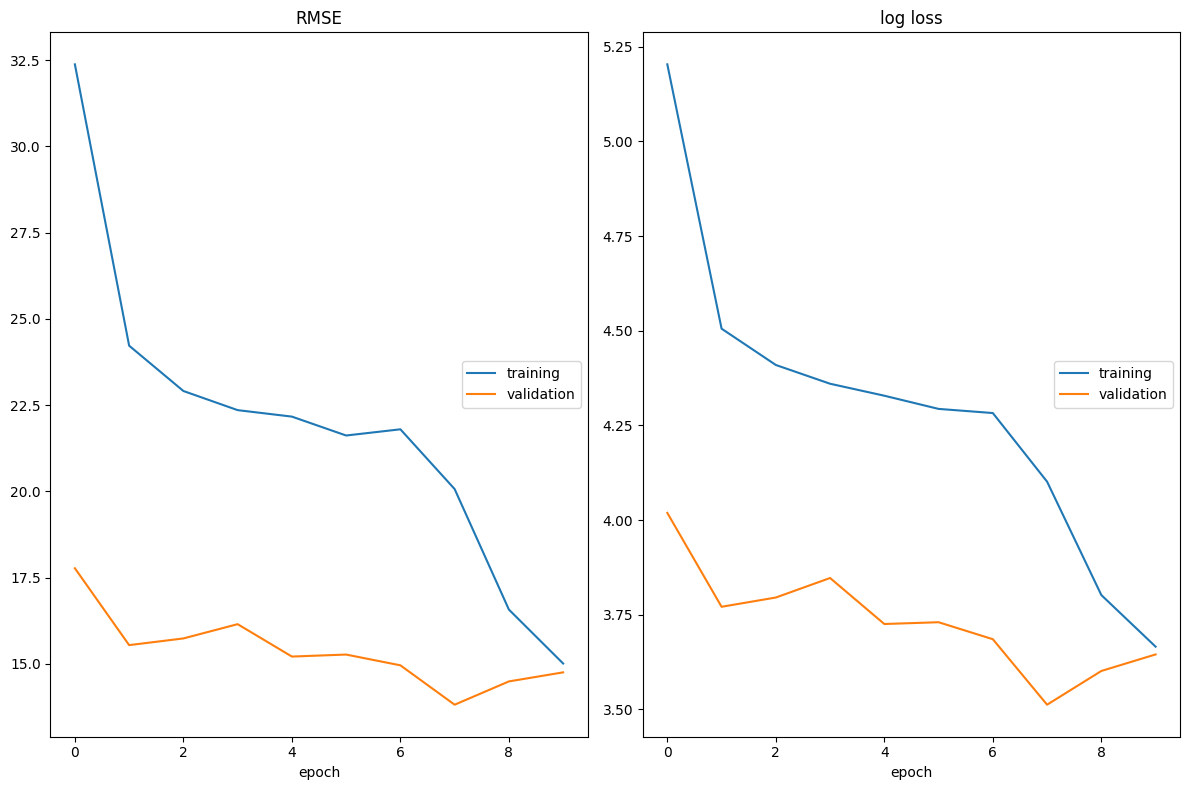

RMSE
	training         	 (min:   15.011, max:   32.374, cur:   15.011)
	validation       	 (min:   13.818, max:   17.771, cur:   14.755)
log loss
	training         	 (min:    3.666, max:    5.204, cur:    3.666)
	validation       	 (min:    3.512, max:    4.019, cur:    3.645)


In [ ]:
# Call the train_model function with the hyperparameters from the PretrainedWindModel class
model = train_model(hparams)

Evaluate against test data set

In [ ]:
csv_file_name = '/content/gdrive/MyDrive/edsmlproj2/data_tst.csv'
test_df = create_test_df(csv_file_name)

In [ ]:
# Preprocess the test data using the same transformations as the training and validation data
test_dataset = DatasetWIND(test_df, transform=DatasetWIND.transform_val)

# Create a data loader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=hparams["batch_size"], shuffle=False, num_workers=hparams["num_workers"])

# Set the model to evaluation mode
model.eval()

# Create empty lists to store the predicted labels and true labels
predicted_labels = []
true_labels = []

# Iterate over the test data loader and make predictions
for batch in test_loader:
    features = batch['image'].to(device)
    labels = batch['label'].to(device).float()

    # Forward pass to get the predicted labels
    with torch.no_grad():
        predictions = model(features)

    # Append the predicted labels and true labels to the respective lists
    predicted_labels.extend(predictions.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

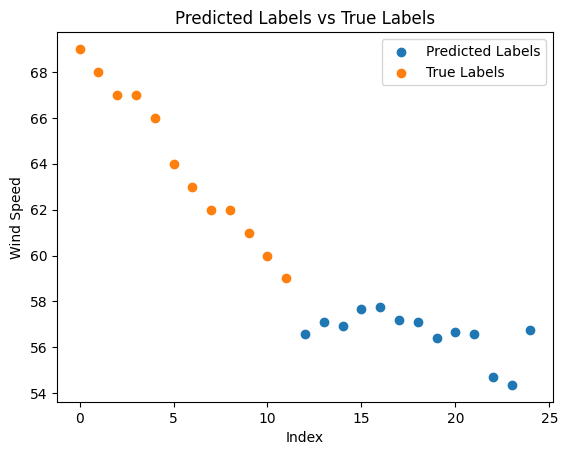

In [ ]:
# Convert the predicted labels and true labels to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

# Get the indices of the test data
indices = np.arange(len(test_dataset))

# Plot the predicted labels against the test data
plt.scatter(indices[-13:], predicted_labels[-13:], label='Predicted Labels')
plt.scatter(indices, true_labels, label='True Labels')
plt.xlabel('Index')
plt.ylabel('Wind Speed')
plt.title('Predicted Labels vs True Labels')
plt.legend()
plt.show()


Creation of CSV files

In [ ]:
csv_file = '/content/gdrive/MyDrive/edsmlproj2/ciaran_windpredictions.csv'

missing_wing_speeds = list(chain.from_iterable(predicted_labels[-13:]))

missing_times = list(test_df['relative_time'][-13:])

In [ ]:
to_csv(csv_file, missing_times, missing_wing_speeds)